# loading SPN code

In [1]:
include("../src/SPN.jl")

INFO: Recompiling stale cache file /Users/martin/.julia/lib/v0.4/BNP.ji for module BNP.


SPN

## Data Assignment Object

In [2]:
type DataAssignments
    
    # number of unique clusters
    c::Int
    
    # assignments
    Z::Vector{Int}
    
    # children
    children::Vector{DataAssignments}
    
    # constructor
    DataAssignments(Z::Vector{Int}) = new(length(unique(Z)), Z, DataAssignments[])
    
end

In [3]:
# functions on DataAssignments
call(p::DataAssignments, idx::Int) = p.Z[idx]
call(p::DataAssignments, ids::Vector{Int}) = p.Z[ids]

function getindex(p::DataAssignments, i::Int)
    find(p.Z .== i)
end

import Base.getindex

In [4]:
# test functions
using Base.Test

# 50% 1, 50% 2
Z = 1 + round(Int, rand(10) .>= 0.5)

d = DataAssignments(Z)

for (i, z) in enumerate(Z)
    @test d(i) == z
end

@test sum(find(Z .== 1) - d[1]) == 0
@test d.c == 2

## Buffer

In [5]:
type SPNBuffer 
   
    # dimensionality of data
    D::Int
    N::Int
    
    # data indecies
    idx::Vector{Int}
    
    # data matrix
    X::AbstractArray{Float32}
    
    # assignment tree
    Z::DataAssignments
    
end

In [6]:
# functions on SPNBuffer
call(p::SPNBuffer, i::Int) = SPNBuffer(p.D, length(p.Z[i]), collect(1:length(p.Z[i])), sub(p.X, :, p.Z[i]), p.Z.children[i])

call (generic function with 1542 methods)

In [7]:
# test functions

N = 10
D = 2
X = rand(2, 10)
idx = collect(1:10)
Z = 1 + vec( round(Int, X[1,:] .>= 0.5) )

da = DataAssignments(Z)

Z1 = ones(Int, length(da[1]))
da1 = DataAssignments(Z1)

Z2 = ones(Int, length(da[2]))
da2 = DataAssignments(Z2)

push!(da.children, da1)
push!(da.children, da2)

# create Buffer Object
B = SPNBuffer(D, N, collect(1:10), X, da)

# create sub Buffer
B2 = B(1)

@test B2.N == length(da1.Z)

## load test data

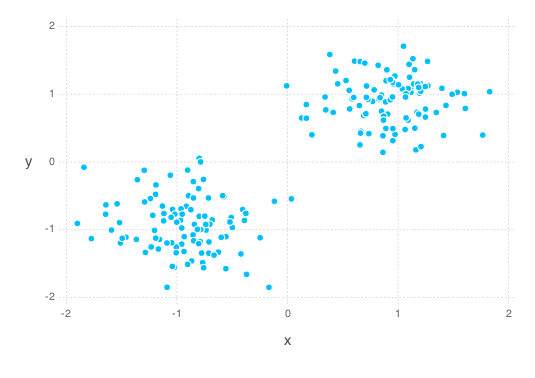

In [8]:
using Gadfly

N = 100

X1 = randn(2, N)
X2 = 5 + randn(2, N)

X = cat(2, X1, X2)

using StatsBase
X = zscore(X, 2)

plot(x = X[1,:], y = X[2,:], Geom.point)

## SPN Definition

In [70]:
# construct initial SPN
using BNP

(D, N) = size(X)

μ0 = vec( zeros(D) )
κ0 = 1.0
ν0 = convert(Float64, D)
Ψ = eye(D)

G0 = GaussianWishart(μ0, κ0, ν0, Ψ);

d = deepcopy(G0)
add_data!(d, X)

# create mv node
dist = SPN.MultivariateNode{ConjugatePostDistribution}(d, collect(1:D))

# create root and add mv node
root = SPN.SumNode(0)
SPN.add!(root, dist)

# create data assignments
Z = vec(ones(Int, N))
da = DataAssignments(Z)

# create Buffer Object
B = SPNBuffer(D, N, collect(1:N), X, da)

SPNBuffer(2,200,[1,2,3,4,5,6,7,8,9,10  …  191,192,193,194,195,196,197,198,199,200],2x200 Array{Float32,2}:
 -0.916295  -1.04041   -0.557087  -1.35886   …  1.24802   0.715922  0.709086
 -0.652913  -0.699114  -1.10177   -0.261589     0.662334  1.12125   0.711803,DataAssignments(1,[1,1,1,1,1,1,1,1,1,1  …  1,1,1,1,1,1,1,1,1,1],DataAssignments[]))

max value: 5

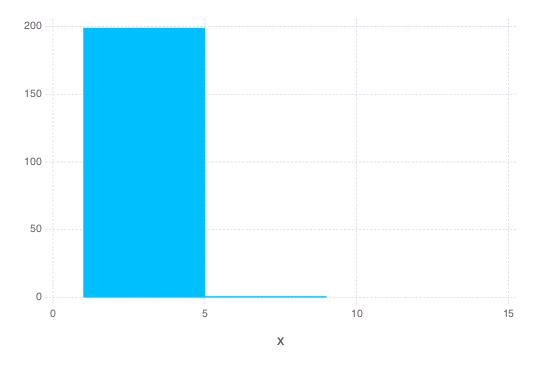

In [79]:
α = 1.0

"Sum Node SPN extension."

#"Single iteration of collabsed Gibbs sampling using CRP."
#function cgibbs_crp!(B::DPMBuffer)

    # randomize data
    shuffle!(B.idx)

    z = -1
    k = -1
    K = B.Z.c

    p = ones(K + 1) * -Inf

    for index in B.idx

        x = B.X[:, index]

        # get assignment
        z = B.Z(index)

        # remove sample from cluster
        # remove_data!(B.G[z], x)

        # remove cluster assignment
        # B.C[z] -= 1

        # remove cluster assignment
        z = -1

        # compute posterior predictive
        for i in 1:K

            llh = SPN.llh(root.children[i], x)[1]
            crp = log( length(B.Z[i]) / B.N + α - 1 )

            p[i] = llh + crp
        end

        p[K + 1] = logpred(G0, x) + log( α / (B.N + α - 1) )
        p = exp(p - maximum(p))

        k = rand_indices(p)

        if k > K
            # add new cluster

            d = deepcopy(G0)
            add_data!(d, x)

            # create mv node
            SPN.add!(root, SPN.MultivariateNode{ConjugatePostDistribution}(d, collect(1:D)) )

            B.Z.c += 1
            K = B.Z.c
            p = ones(K + 1) * -Inf

        else
          # add to cluster
          #add_data!(B.G[k], x)
        end

        B.Z.Z[index] = k
    end

#  B
#end

println("max value: ", maximum(B.Z.Z))

plot(x = B.Z.Z, Geom.histogram)